# Setup Variables and home directory

MNIST, FashionMNIST, GTSRB, Cifar10

In [1]:
DATASET = 'GTSRB'
SEED = 42
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [2]:
# set homw directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [6]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fastprogress import progress_bar

from utilities.utils import load_json, load_pickle, get_models
from utilities.pathManager import fetchPaths
from utilities.MonitorUnifiedBDD import MonitorBDD

In [4]:
# print available models
model_names = get_models(base, DATASET)
for i, m in enumerate(model_names): print(i, m)

0 AdamW-32-30
1 AdamW-32-50
2 Adam-128-50
3 AdamW-32-80
4 AdamW-32-150
5 Adam-128-150
6 AdamW-32-200
7 AdamW-32-400
8 AdamW-32-800


In [5]:
POSTFIX = model_names[1]
FILENAME_POSTFIX = f'{DATASET}_{POSTFIX}'

FILENAME_POSTFIX

'GTSRB_AdamW-32-50'

# Paths

In [7]:
paths = fetchPaths(base, DATASET, POSTFIX, False)

path_data = paths['data']
path_lhl = paths['lhl']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_scaler_pca']

# Seed

In [8]:
np.random.seed(SEED)

# Import Data

In [18]:
FLAVOR = 'raw'

if FLAVOR == 'raw':
    path_lhl = path_lhl_raw
else: path_lhl = path_lhl_pca

# import Data
df_train = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_train.csv")
df_test = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_test.csv")
df_eval = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_evaluation.csv")

# select only true classified
df_true = pd.concat([df_train[df_train["true"] == True].copy(),df_test[df_test["true"] == True].copy()])
df_true = df_true.drop("true", axis=1).reset_index(drop=True)
# df_true = df_train[df_train["true"] == True].copy()
# df_true = df_true.drop("true", axis=1).reset_index(drop=True)

# Shuffel and Split indecies

In [19]:
indecies = {}
u_bound = df_true['y'].value_counts().max()
classes = df_true['y'].drop_duplicates().sort_values().values

for c in classes:
    indecies[c] = df_true.loc[df_true['y'] == c].index.values
    np.random.shuffle(indecies[c])

In [20]:
sum([len(i) for i in indecies.values()]) == df_true.shape[0]

True

# Build BDD

In [28]:
# each set of data has its own threshold
thld_p = 0.5
eta = 0
neurons = []


# save scores and stats
stats = pd.DataFrame()
train_scores = pd.DataFrame()
test_scores = pd.DataFrame()
eval_scores = pd.DataFrame()

# number of instances per class
step = 100

# progress bar
# take {step} instances each loop from all calsses
pb = progress_bar(range(step, u_bound+step, step))

# buidl for each i
for i in pb:
    
    # indecies
    ix = np.concatenate([v[:i] for v in indecies.values()], axis=None)
    
    # calculate threshold
    thld = np.quantile( df_true.loc[ix].drop('y', axis=1), thld_p)
    
    # BDD
    patterns = MonitorBDD( df_true.loc[ix].shape[1]-1, thld, neurons=neurons)
    df_train_copy, df_test_copy, df_eval_copy = patterns.add_dataframe( df_true.loc[ix], eta,
                            eval_dfs=[df_train.copy(), df_test.copy(), df_eval.copy()])

    
    # score
    df_train_scores = patterns.score_dataframe_multi_eta(df_train_copy, eta)
    df_test_scores = patterns.score_dataframe_multi_eta(df_test_copy, eta)
    df_eval_scores = patterns.score_dataframe_multi_eta(df_eval_copy, eta)

    
    # add metadata
    patterns.stats['thld'] = f'qth_{thld_p}'
    patterns.stats['period'] = i
    patterns.stats['num_observations'] = ix.shape[0]
    df_train_scores['period'] = i
    df_train_scores['num_observations'] = ix.shape[0]
    df_test_scores['period'] = i
    df_test_scores['num_observations'] = ix.shape[0]
    df_eval_scores['period'] = i
    df_eval_scores['num_observations'] = ix.shape[0]
    
    
    # collect scores
    stats = pd.concat([stats, patterns.stats])
    train_scores = pd.concat([train_scores, df_train_scores])
    test_scores = pd.concat([test_scores, df_test_scores])
    eval_scores = pd.concat([eval_scores, df_eval_scores])

In [29]:
stats

,thld,eta,build_time_min,size_mb,reorder_time_min,num_patterns,num_unique_patterns_%,num_reorder,num_neurons,start_time,end_time,period,num_observations
1,qth_0.5,0.0,1.6,4311.843,2319069.5,4300.0,93.5,0.0,50.0,2023-08-06 12:45:08,2023-08-06 12:45:09,100,4300
1,qth_0.5,0.0,3.0,4319.199,2319110.7,8600.0,88.0,0.0,50.0,2023-08-06 12:45:32,2023-08-06 12:45:34,200,8600
1,qth_0.5,0.0,3.2,4320.572,2319152.2,12900.0,83.7,0.0,50.0,2023-08-06 12:45:57,2023-08-06 12:45:58,300,12900
1,qth_0.5,0.0,4.4,4321.505,2319190.5,17200.0,80.2,0.0,50.0,2023-08-06 12:46:19,2023-08-06 12:46:21,400,17200
1,qth_0.5,0.0,5.2,4323.011,2319233.0,21500.0,77.3,0.0,50.0,2023-08-06 12:46:44,2023-08-06 12:46:47,500,21500
1,qth_0.5,0.0,6.3,4335.087,2319276.3,25800.0,74.4,0.0,50.0,2023-08-06 12:47:09,2023-08-06 12:47:13,600,25800
1,qth_0.5,0.0,7.2,4335.725,2319320.6,30100.0,72.2,0.0,50.0,2023-08-06 12:47:35,2023-08-06 12:47:40,700,30100
1,qth_0.5,0.0,10.0,4336.513,2319374.3,34400.0,70.2,0.0,50.0,2023-08-06 12:48:06,2023-08-06 12:48:12,800,34400
1,qth_0.5,0.0,11.5,4337.070,2319431.9,38700.0,68.1,0.0,50.0,2023-08-06 12:48:39,2023-08-06 12:48:46,900,38700
1,qth_0.5,0.0,11.5,4337.495,2319490.3,43000.0,66.4,0.0,50.0,2023-08-06 12:49:14,2023-08-06 12:49:21,1000,43000


In [30]:
train_scores.loc[ train_scores['y'] == 'all' ]

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta,period,num_observations
43,all,63968.0,52223.0,2345.0,49878.0,0.816393,0.044904,0.955096,0,100,4300
43,all,63968.0,44198.0,2344.0,41854.0,0.690939,0.053034,0.946966,0,200,8600
43,all,63968.0,37829.0,2344.0,35485.0,0.591374,0.061963,0.938037,0,300,12900
43,all,63968.0,32548.0,2344.0,30204.0,0.508817,0.072017,0.927983,0,400,17200
43,all,63968.0,27941.0,2344.0,25597.0,0.436797,0.083891,0.916109,0,500,21500
43,all,63968.0,24112.0,2344.0,21768.0,0.376938,0.097213,0.902787,0,600,25800
43,all,63968.0,20779.0,2344.0,18435.0,0.324834,0.112806,0.887194,0,700,30100
43,all,63968.0,17708.0,2343.0,15365.0,0.276826,0.132313,0.867687,0,800,34400
43,all,63968.0,15009.0,2343.0,12666.0,0.234633,0.156106,0.843894,0,900,38700
43,all,63968.0,12570.0,2343.0,10227.0,0.196505,0.186396,0.813604,0,1000,43000


In [31]:
test_scores.loc[ test_scores['y'] == 'all' ]

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta,period,num_observations
43,all,4192.0,3582.0,154.0,3428.0,0.854485,0.042993,0.957007,0,100,4300
43,all,4192.0,3148.0,154.0,2994.0,0.750954,0.048920,0.951080,0,200,8600
43,all,4192.0,2730.0,154.0,2576.0,0.651240,0.056410,0.943590,0,300,12900
43,all,4192.0,2435.0,154.0,2281.0,0.580868,0.063244,0.936756,0,400,17200
43,all,4192.0,2116.0,153.0,1963.0,0.504771,0.072306,0.927694,0,500,21500
43,all,4192.0,1790.0,153.0,1637.0,0.427004,0.085475,0.914525,0,600,25800
43,all,4192.0,1541.0,153.0,1388.0,0.367605,0.099286,0.900714,0,700,30100
43,all,4192.0,1304.0,153.0,1151.0,0.311069,0.117331,0.882669,0,800,34400
43,all,4192.0,1124.0,153.0,971.0,0.268130,0.136121,0.863879,0,900,38700
43,all,4192.0,935.0,153.0,782.0,0.223044,0.163636,0.836364,0,1000,43000


In [33]:
eval_scores.loc[ eval_scores['y'] == 'all' ]

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta,period,num_observations
1,all,1000.0,1000.0,0.0,1000.0,1.0,1.0,0.0,0,100,4300
1,all,1000.0,1000.0,0.0,1000.0,1.0,1.0,0.0,0,200,8600
1,all,1000.0,1000.0,0.0,1000.0,1.0,1.0,0.0,0,300,12900
1,all,1000.0,1000.0,0.0,1000.0,1.0,1.0,0.0,0,400,17200
1,all,1000.0,1000.0,0.0,1000.0,1.0,1.0,0.0,0,500,21500
1,all,1000.0,1000.0,0.0,1000.0,1.0,1.0,0.0,0,600,25800
1,all,1000.0,1000.0,0.0,1000.0,1.0,1.0,0.0,0,700,30100
1,all,1000.0,1000.0,0.0,1000.0,1.0,1.0,0.0,0,800,34400
1,all,1000.0,1000.0,0.0,1000.0,1.0,1.0,0.0,0,900,38700
1,all,1000.0,1000.0,0.0,1000.0,1.0,1.0,0.0,0,1000,43000


<Axes: xlabel='period', ylabel='false'>

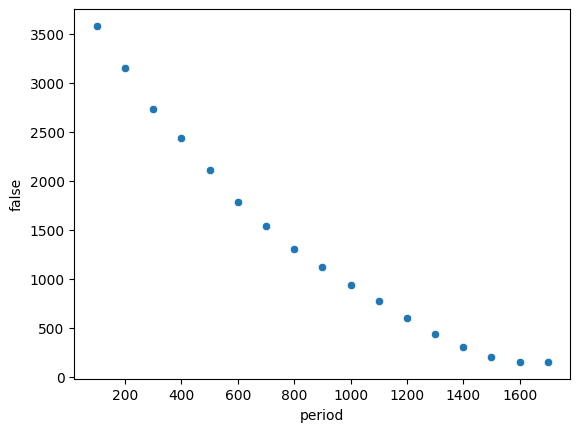

In [36]:
sns.scatterplot(data=test_scores.loc[ test_scores['y'] == 'all' ],
                x='period', y='false')

<Axes: xlabel='period', ylabel='outOfPatternMisclassified'>

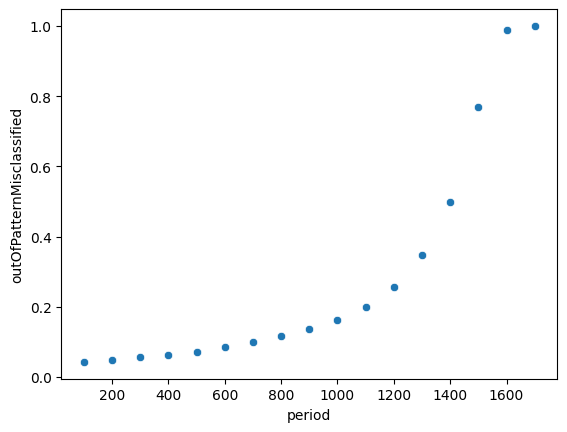

In [37]:
sns.scatterplot(data=test_scores.loc[ test_scores['y'] == 'all' ], x='period', y='outOfPatternMisclassified')

In [40]:
df_train_copy.loc[(df_train_copy['bdd_0'] == 1) & (df_train_copy['true'] == False)]

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x43,x44,x45,x46,x47,x48,x49,y,true,bdd_0
17989,29.386587,-4.712198,-13.823545,-18.626612,-14.512881,21.917961,22.744568,10.860001,21.039097,12.236872,...,0.068467,-5.739902,14.902786,13.369600,1.742700,0.004893,10.740401,41,False,1
21092,-11.918087,7.860774,5.912345,3.966959,2.208384,-3.565394,-5.486997,8.681404,-1.410180,-0.970910,...,-1.487343,3.141920,11.697464,-7.272502,7.148226,11.444244,-0.193490,0,False,1
54452,-4.685332,5.589707,17.244606,-25.860649,8.796307,13.516533,19.620831,17.683018,-19.030270,-2.388646,...,2.204149,9.507368,-11.070246,10.451853,-7.380628,-6.364187,12.537891,39,False,1
54726,4.888744,-1.915333,4.221381,-15.491490,-10.557854,10.844392,7.443777,14.279541,-17.444439,-1.286101,...,7.371009,0.049809,0.107769,4.861952,17.042744,-0.243474,-4.136525,34,False,1


In [41]:
df_test_copy.loc[(df_test_copy['bdd_0'] == 1) & (df_test_copy['true'] == False)]

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x43,x44,x45,x46,x47,x48,x49,y,true,bdd_0
1056,3.594564,8.037528,9.437267,-15.448446,-11.748388,-3.788365,21.768116,11.618607,-17.971355,-6.231822,...,5.990324,8.446477,-0.991342,4.93865,11.885002,-5.329642,8.782752,40,False,1


In [43]:
df_eval_copy.loc[(df_eval_copy['bdd_0'] == 1) & (df_eval_copy['true'] == True)]

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x43,x44,x45,x46,x47,x48,x49,y,true,bdd_0
